In [17]:

import torch
import torchvision
torchvision.disable_beta_transforms_warning()
from models import VideoModel
from dataset import VideoDataset, TestDatasets
from transforms import build_transforms
from torchmetrics import Accuracy, F1Score, ConfusionMatrix, Precision, Recall
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from tqdm import tqdm
from utils import set_seed
import numpy as np
from typing import List
import os
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(42)

EXPS = {exp_name:f'lightning_logs/{exp_name}/version_0/checkpoints/best_model.ckpt' for exp_name in os.listdir('lightning_logs') if os.path.isdir(f'lightning_logs/{exp_name}')}

def count_videos_by_class():
    for root, _, files in os.walk('../MINDS_tensors'):
        print(f'{root} has {len(files)} tensors')
        
def load_dataset(mode="val", dir="../MINDS_tensors_all_frames"):
    if mode == "val":
        return VideoDataset(
            root_dir=dir,
            extensions=["pt"],
            transform=build_transforms(
                ["normalize"],
                resize_dims=(224, 224),
                sample_frames=16,
                random_sample=False,
            ),
            split="test",
            with_path=True,
        )
    else:
        return TestDatasets(
            "./dataset_intersections/common_labels.csv",
            transforms=build_transforms(
                ["normalize"], resize_dims=(224, 224), random_sample=False
            ),
        )
        
def load_model(model_path):
    model = VideoModel.load_from_checkpoint(
        model_path
    )
    model.eval()
    model = model.to(device)
    return model

@dataclass
class LogTemplate():
    exp_name: str
    acc_32_frames: float
    f1_32_frames: float
    precision_32_frames: float
    recall_32_frames: float
    cm_32_frames: np.ndarray
    errors_32_frames: List[str]
    acc_all_frames: float
    f1_all_frames: float
    precision_all_frames: float
    recall_all_frames: float
    cm_all_frames: np.ndarray
    errors_all_frames: List[str]
    acc_test: float
    f1_test: float
    precision_test: float
    recall_test: float
    cm_test: np.ndarray
    errors_test: List[str]
    
class Results():
    def __init__(self):
        self.wrong_paths = []
        self.accuracy = Accuracy(task='multiclass', num_classes=20).to(device)
        self.f1 = F1Score(task='multiclass', num_classes=20).to(device)
        self.cm = ConfusionMatrix(task='multiclass', num_classes=20).to(device)
        self.precision = Precision(task='multiclass', num_classes=20).to(device)
        self.recall = Recall(task='multiclass', num_classes=20).to(device)
        
    def __call__(self, true, pred):
        self.accuracy(pred, true)
        self.f1(pred, true)
        self.cm(pred, true)
        self.precision(pred, true)
        self.recall(pred, true)
        
    def add_to_wrong_paths(self, path):
        self.wrong_paths.append(path)
        
    def get_metrics(self):
        return self.accuracy.compute().item(), self.f1.compute().item(), self.precision.compute().item(), self.recall.compute().item(), self.cm.compute().cpu().numpy(), self.wrong_paths

In [5]:
# run every experiment for all the three datasets and get the values of the metrics
all_results = []

for k,v in EXPS.items():
    print(f'Experiment: {k}')
    model = load_model(v)
    val_all_frames = load_dataset("val", "../MINDS_tensors_all_frames")
    val_32_frames = load_dataset("val", "../MINDS_tensors_32")
    test_dataset = load_dataset("test")
    
    exp_results = []
    
    with torch.no_grad():
        for dataset in [val_all_frames, val_32_frames]:
            loader = torch.utils.data.DataLoader(
                dataset,
                batch_size=1,
                shuffle=False,
                num_workers=32,
            )
            
            dataset_results = Results()
            
            for i, (video, label, path, _) in enumerate(tqdm(loader)):
                video = video.to(device)
                label = label.to(device)
                output = model(video)
                pred = torch.argmax(output.logits, dim=1)
                dataset_results(pred, label)
                if label != pred:
                    dataset_results.add_to_wrong_paths(path)
                
            
            exp_results.append(dataset_results.get_metrics())
        
        test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=1,
        )
        
        test_results = Results()
        
        for i, (video, label, origin, path) in enumerate(tqdm(test_loader)):
            video = video.to(device)
            output = model(video)
            pred = torch.argmax(output.logits, dim=1)
            label = label[0].split('_')[0]
            label = label.replace('á', 'a').replace('ã', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u').replace('ç', 'c')
            label = val_32_frames.class_to_idx[label]
            label = torch.tensor([label])
            label = label.to(device)
            test_results(pred, label)
            if label != pred:
                test_results.add_to_wrong_paths(path)
        
        exp_results.append(test_results.get_metrics())
        
        experiment = LogTemplate(
            k,
            exp_results[0][0],
            exp_results[0][1],
            exp_results[0][2],
            exp_results[0][3],
            exp_results[0][4],
            exp_results[0][5],
            exp_results[1][0],
            exp_results[1][1],
            exp_results[1][2],
            exp_results[1][3],
            exp_results[1][4],
            exp_results[1][5],
            exp_results[2][0],
            exp_results[2][1],
            exp_results[2][2],
            exp_results[2][3],
            exp_results[2][4],
            exp_results[2][5]        
        )
        
        all_results.append(experiment)
        break
    

Experiment: video_mae_kinetics_sample_from_32


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([20, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/72 [00:00<?, ?it/s]/home/parraga/miniconda3/envs/libras/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
100%|██████████| 72/72 [02:43<00:00,  2.27s/it]


In [2]:
# run every experiment for all the three datasets and get the values of the metrics
all_results = {e:[] for e in EXPS.keys()}

val_all_frames = load_dataset("val", "../MINDS_tensors_all_frames")
val_32_frames = load_dataset("val", "../MINDS_tensors_32")
test_dataset = load_dataset("test")
loader_val_all_frames = torch.utils.data.DataLoader(
    val_all_frames,
    batch_size=1,
    shuffle=False,
    num_workers=32,
)
loader_val_32_frames = torch.utils.data.DataLoader(
    val_32_frames,
    batch_size=1,
    shuffle=False,
    num_workers=32,
)
loader_test = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
)

loaders = [loader_val_all_frames, loader_val_32_frames, loader_test]

for k,v in EXPS.items():
    print(f'Experiment: {k}')
    model = load_model(v)
    exp_results = []
    
    with torch.no_grad():        
        for loader in loaders:
            dataset_results = []
            for (video, label, origin, path) in tqdm(loader):
                video = video.to(device)
                output = model(video)
                pred = torch.argmax(output.logits, dim=1)
                dataset_results.append(pred.item())
            exp_results.append(dataset_results)
    all_results[k] = exp_results
    break
    

Experiment: video_mae_kinetics_sample_from_32


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([20, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/72 [00:00<?, ?it/s]/home/parraga/miniconda3/envs/libras/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
100%|██████████| 72/72 [04:09<00:00,  3.47s/it]


In [52]:
# Build labels array
labels_all_frames = val_all_frames.samples
labels_test = test_dataset.df['label'].values
dictionary_test = test_dataset.df['dictionary'].values
paths_test = test_dataset.df['path'].values

# Treat Validation set Results
* Output a csv file with metrics for each model in the validation set, considering 32 frames and all frames

In [32]:
class ResultAnalyzer():
    def __init__(self, true, preds):
        self.true = [i[1] for i in true]
        self.paths = [i[0] for i in true]
        self.preds = preds
        self.errors = []
    
    def compute_metrics(self):
        # compute accuracy, f1, precision, recall and confusion matrix
        # accuracy = np.mean(np.array(self.true) == np.array(self.preds))
        accuracy = accuracy_score(self.true, self.preds)
        f1 = f1_score(self.true, self.preds, average='macro')
        precision = precision_score(self.true, self.preds, average='macro')
        recall = recall_score(self.true, self.preds, average='macro')
        cm = confusion_matrix(self.true, self.preds)
        
        return accuracy, f1, precision, recall, cm
    
    def get_errors(self):
        for i in range(len(self.true)):
            if self.true[i] != self.preds[i]:
                self.errors.append(self.paths[i])
        return self.errors


In [44]:
# save the ra for each model in a dictionary {{model_name: , acc_32: , f1_32: , precision_32: , recall_32: , cm_32: , errors_32: , acc_all: , f1_all: , precision_all: , recall_all: , cm_all: , errors_all: }}
final_csv = {}
for k,v in all_results.items():
    print(k,v)
    ra_32 = ResultAnalyzer(labels_all_frames, v[0])
    ra_all = ResultAnalyzer(labels_all_frames, v[1])
    
    acc_32, f1_32, precision_32, recall_32, cm_32 = ra_32.compute_metrics()
    acc_all, f1_all, precision_all, recall_all, cm_all = ra_all.compute_metrics()
    errors_32 = ra_32.get_errors()
    errors_all = ra_all.get_errors()
    
    final_csv[k] = {
        'model_name': k,
        'acc_32': acc_32,
        'f1_32': f1_32,
        'precision_32': precision_32,
        'recall_32': recall_32,
        'cm_32': cm_32,
        'errors_32': errors_32,
        'acc_all': acc_all,
        'f1_all': f1_all,
        'precision_all': precision_all,
        'recall_all': recall_all,
        'cm_all': cm_all,
        'errors_all': errors_all,
    }
    
# save dataframe to csv
df = pd.DataFrame.from_dict(final_csv, orient='index')
df.to_csv('results.csv')

video_mae_kinetics_sample_from_32 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 18, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1

# Treat Test set Results
* Output a csv file, considering each video and how each model predicted it

In [53]:
# transform labels to Minds labels
true_test = [t.split('_')[0] for t in labels_test]
# remove accents from labels
true_test = [t.replace('á', 'a').replace('ã', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u').replace('ç', 'c') for t in true_test]

true_test = [val_all_frames.class_to_idx[t] for t in true_test]

true_test = [(path, t) for path, t in zip(paths_test, true_test)]

In [55]:
for k,v in all_results.items():
    print(k,v)
    ra_test = ResultAnalyzer(true_test, v[2])
    
    acc, f1, precision, recall, cm = ra_test.compute_metrics()
    errors = ra_test.get_errors()
    
    final_csv[k] = {
        'model_name': k,
        'acc': acc,
        'f1': f1,
        'precision_32': precision,
        'recall_32': recall,
        'cm_32': cm,
        'errors_32': errors,
    }
    break

# save dataframe to csv
df = pd.DataFrame.from_dict(final_csv, orient='index')
df.to_csv('results_test.csv')

video_mae_kinetics_sample_from_32 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 18, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1

/home/parraga/miniconda3/envs/libras/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parraga/miniconda3/envs/libras/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
# save a column for each model prediction in original test dataframe
for k,v in all_results.items():
    test_dataset.df[k] = v[2]
    break

test_dataset.df.to_csv('test_results_model_by_column.csv')

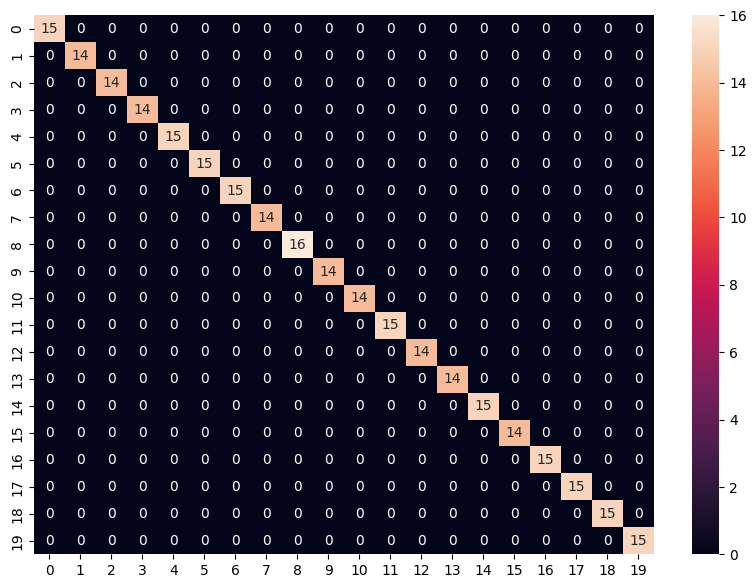

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_cm = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(20)],
                    columns = [i for i in range(20)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.show()

In [28]:
test_dataset = TestDatasets(
    './dataset_intersections/common_labels.csv',
    transforms=build_transforms(['normalize'],
                                resize_dims=(224, 224),
                                random_sample=False),
    )

In [34]:
results_test_dataset = Results()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

for i, (video, label, origin, path) in tqdm(enumerate(test_loader), total=len(test_dataset)):
    with torch.no_grad():
        video = video.to(device)
        output = model(video)
        pred = torch.argmax(output.logits, dim=1)
        label = label[0].split('_')[0]
        label = label.replace('á', 'a').replace('ã', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u').replace('ç', 'c')
        label = val_dataset.class_to_idx[label]
        label = torch.tensor([label])
        label = label.to(device)
        results_test_dataset(label, pred)

  0%|          | 0/72 [00:00<?, ?it/s]

/home/parraga/miniconda3/envs/libras/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
  6%|▌         | 4/72 [01:49<30:56, 27.30s/it]


KeyboardInterrupt: 

In [35]:
print(f'Accuracy: {results_test_dataset.accuracy.compute()}')
print(f'F1: {results_test_dataset.f1.compute()}')
print(f'Precision: {results_test_dataset.precision.compute()}')
print(f'Recall: {results_test_dataset.recall.compute()}')

Accuracy: 0.75
F1: 0.75
Precision: 0.75
Recall: 0.75


In [42]:
# transform labels to Minds labels
true_test = [t[0].split('_')[0] for t in true_test]
# remove accents from labels
true_test = [t.replace('á', 'a').replace('ã', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u').replace('ç', 'c') for t in true_test]

true_test = [val_dataset.class_to_idx[t] for t in true_test]

# [val_dataset.class_to_idx[t[0].split('_')[0]] for t in true_test]

In [43]:
accuracy = sum([1 for i, j in zip(preds_test, true_test) if i == j]) / len(true_test)

confusion_matrix = torch.zeros(20, 20)
for t, p in zip(true_test, preds_test):
    confusion_matrix[t, p] += 1
    
precision = confusion_matrix.diag() / confusion_matrix.sum(1)
recall = confusion_matrix.diag() / confusion_matrix.sum(0)
f1 = 2 * precision * recall / (precision + recall)

In [44]:
print(f'Accuracy: {accuracy}')
print(f'F1: {f1.mean()}')
print(f'Precision: {precision.mean()}')
print(f'Recall: {recall.mean()}')


Accuracy: 0.4246575342465753
F1: nan
Precision: nan
Recall: nan


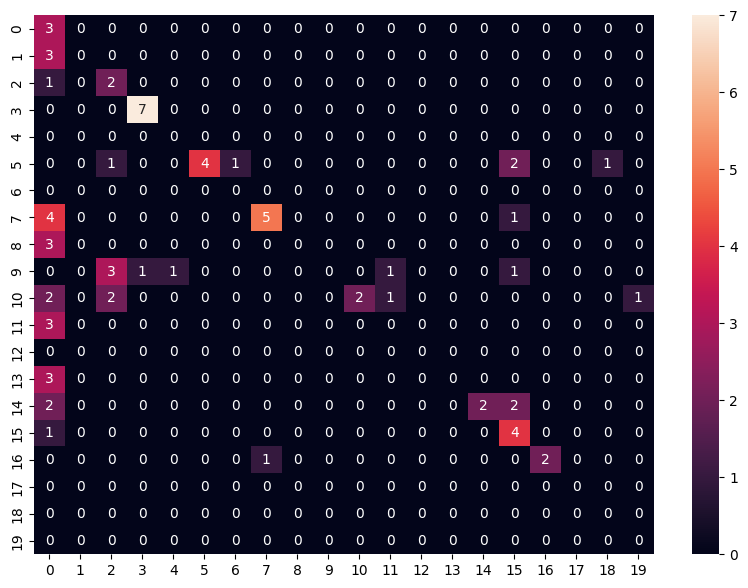

In [45]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_cm = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(20)],
                    columns = [i for i in range(20)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.show()